# Sentiment Analysis of News Headlines and relation With Stocks

In [98]:
from collections import defaultdict
from pyspark import SparkContext
from pyspark.sql import SQLContext
import re
import nltk
import datetime as datetime



sc

<SparkContext master=local[2] appName=PySparkShell>

In [3]:
#Loading the file into the RDD
data = sc.textFile("file:///home/prateek-01/Downloads/BDM_Project/india-news-headlines.txt")


#Splitting by comma and choosing the third column i.e newsheadlines 
#Removing whitespaces(leading and tailing) and converting all words to lowercase
tokens = data.map(lambda headline : ( headline.split(',')[0],headline.split(',')[2].lower()))#.mapvalue( lambda headline: headline.strip().lower())

# tokens = sc.parallelize(tokens.take(5000))   #sampling


tokens.take(5)

[('20010101', '"send money to india the safe convenient inexpensive way"'),
 ('20010101', '"sbi to divest up to 10 stake in its life insurance venture"'),
 ('20010101', '"godrej properties to develop housing project at bengaluru"'),
 ('20010101',
  '"australian green lobby drags adani group to court over mine project"'),
 ('20010101', '"sensex falls 18 points climbs 25 in fiscal 2014 15"')]

In [4]:
print(" The news headlines dataset has {} records".format(tokens.count())) # 2.6 millions headlines

 The news headlines dataset has 2665614 records


### Creating a word-vector for every news headline and parsing the dates
### And Tokenizing (splitting using regex)

In [5]:


token1 = tokens.map( lambda headline: (datetime.datetime(int(headline[0][0:4]), int(headline[0][4:6]), int(headline[0][6:8])),[re.sub('[^a-zA-Z0-9]','', word )for word in headline[1].split(' ')]))

token1.take(1)

[(datetime.datetime(2001, 1, 1, 0, 0),
  ['send',
   'money',
   'to',
   'india',
   'the',
   'safe',
   'convenient',
   'inexpensive',
   'way'])]

### Identifying the Top occuring words

In [6]:
termCounts = token1                            \
    .flatMap(lambda heading: heading[1])         \
    .map(lambda word: (word, 1))                \
    .reduceByKey( lambda x,y: x + y)            \
    .map(lambda tuple: (tuple[1], tuple[0]))    \
    .sortByKey(False)

In [7]:
termCounts.take(10)

[(662375, 'to'),
 (547521, 'in'),
 (370866, 'for'),
 (271687, 'of'),
 (247161, 'on'),
 (161199, 'a'),
 (145172, 'the'),
 (124581, 'at'),
 (97282, 'with'),
 (82215, 'from')]

In [34]:
# try to create a word distribution plot here/ word cloud with meaningful most occuring words

#word cloud ->https://github.com/amueller/word_cloud

from wordcloud import WordCloud

### identifying  a threshold to remove the top words(which are not already included the defuult stopwors list), i.e remove stop words

In [36]:
num_of_stop_words = 30      # Number of most common words to remove, trying to eliminate stop words

threshold = termCounts.take(num_of_stop_words)[num_of_stop_words - 1][0]

threshold

38615

### Default list of Stopwords + Combining your own list of Stopwords

In [10]:


stopwords_core = ['a', u'about', u'above', u'after', u'again', u'against', u'all', u'am', u'an', u'and', u'any', u'are', u'arent', u'as', u'at', u'be', u'because', u'been', u'before', u'being', u'below', u'between', u'both', u'but', u'by', 
    u'can', 'cant', 'come', u'could', 'couldnt', 
    u'd', u'did', u'didn', u'do', u'does', u'doesnt', u'doing', u'dont', u'down', u'during', 
    u'each', 
    u'few', 'finally', u'for', u'from', u'further', 
    u'had', u'hadnt', u'has', u'hasnt', u'have', u'havent', u'having', u'he', u'her', u'here', u'hers', u'herself', u'him', u'himself', u'his', u'how', 
    u'i', u'if', u'in', u'into', u'is', u'isnt', u'it', u'its', u'itself', 
    u'just', 
    u'll', 
    u'm', u'me', u'might', u'more', u'most', u'must', u'my', u'myself', 
    u'no', u'nor', u'not', u'now', 
    u'o', u'of', u'off', u'on', u'once', u'only', u'or', u'other', u'our', u'ours', u'ourselves', u'out', u'over', u'own', 
    u'r', u're', 
    u's', 'said', u'same', u'she', u'should', u'shouldnt', u'so', u'some', u'such', 
    u't', u'than', u'that', 'thats', u'the', u'their', u'theirs', u'them', u'themselves', u'then', u'there', u'these', u'they', u'this', u'those', u'through', u'to', u'too', 
    u'under', u'until', u'up', 
    u'very', 
    u'was', u'wasnt', u'we', u'were', u'werent', u'what', u'when', u'where', u'which', u'while', u'who', u'whom', u'why', u'will', u'with', u'wont', u'would', 
    u'y', u'you', u'your', u'yours', u'yourself', u'yourselves']
    

    
    # Custom List of Stopwords(handpicked based on frequency count in the previous cell)
stopwords_custom = [u'india',u'indian',u'new','rs','govt', 'always','police']
stopwords = stopwords_core + stopwords_custom
stopwords = [word.lower() for word in stopwords]    

## Removal of stopwords

In [11]:


token_final = token1.map( lambda word: (word[0],[x for x in word[1] if  x.lower() not in stopwords]) )
#len(x) > 2 and
token_final.take(5)

[(datetime.datetime(2001, 1, 1, 0, 0),
  ['send', 'money', 'safe', 'convenient', 'inexpensive', 'way']),
 (datetime.datetime(2001, 1, 1, 0, 0),
  ['sbi', 'divest', '10', 'stake', 'life', 'insurance', 'venture']),
 (datetime.datetime(2001, 1, 1, 0, 0),
  ['godrej', 'properties', 'develop', 'housing', 'project', 'bengaluru']),
 (datetime.datetime(2001, 1, 1, 0, 0),
  ['australian',
   'green',
   'lobby',
   'drags',
   'adani',
   'group',
   'court',
   'mine',
   'project']),
 (datetime.datetime(2001, 1, 1, 0, 0),
  ['sensex', 'falls', '18', 'points', 'climbs', '25', 'fiscal', '2014', '15'])]

### Joining back the tokenized vector into a string of words

In [12]:
rdd_final = token_final.map(lambda x :(x[0], " ".join(x[1])))

rdd_final.take(2)

[(datetime.datetime(2001, 1, 1, 0, 0),
  'send money safe convenient inexpensive way'),
 (datetime.datetime(2001, 1, 1, 0, 0),
  'sbi divest 10 stake life insurance venture')]

### Converting RDD to Spark Dataframe

In [13]:
from pyspark.sql import Row

def list_to_row(keys, values):
    row_dict = dict(zip(keys, values))
    return Row(**row_dict)

In [14]:
rdd_rows = rdd_final.map(lambda x: list_to_row(['Publish_Date','news'], x))
rdd_rows.take(3)

[Row(Publish_Date=datetime.datetime(2001, 1, 1, 0, 0), news='send money safe convenient inexpensive way'),
 Row(Publish_Date=datetime.datetime(2001, 1, 1, 0, 0), news='sbi divest 10 stake life insurance venture'),
 Row(Publish_Date=datetime.datetime(2001, 1, 1, 0, 0), news='godrej properties develop housing project bengaluru')]

In [15]:
news_headlines_df = spark.createDataFrame(rdd_rows)
news_headlines_df.show(10,False)

news_headlines_df.cache()

+-------------------+-----------------------------------------------------------+
|Publish_Date       |news                                                       |
+-------------------+-----------------------------------------------------------+
|2001-01-01 00:00:00|send money safe convenient inexpensive way                 |
|2001-01-01 00:00:00|sbi divest 10 stake life insurance venture                 |
|2001-01-01 00:00:00|godrej properties develop housing project bengaluru        |
|2001-01-01 00:00:00|australian green lobby drags adani group court mine project|
|2001-01-01 00:00:00|sensex falls 18 points climbs 25 fiscal 2014 15            |
|2001-01-01 00:00:00|gas price cut 8 466 per unit                               |
|2001-01-01 00:00:00|sbi dilute stake life insurance wing 10                    |
|2001-01-01 00:00:00|april 1 shell eating business class flights                |
|2001-01-01 00:00:00|high duty push gold smuggling assocham                     |
|2001-01-01 00:0

DataFrame[Publish_Date: timestamp, news: string]

### Converting Publish_Date from 'string' to 'date' type object

In [16]:


from pyspark.sql.types import DateType
news_df1 = news_headlines_df.withColumn("Publish_Date",news_headlines_df['Publish_Date'].cast(DateType()))

In [17]:
news_df1.show(5)

news_df1

+------------+--------------------+
|Publish_Date|                news|
+------------+--------------------+
|  2001-01-01|send money safe c...|
|  2001-01-01|sbi divest 10 sta...|
|  2001-01-01|godrej properties...|
|  2001-01-01|australian green ...|
|  2001-01-01|sensex falls 18 p...|
+------------+--------------------+
only showing top 5 rows



DataFrame[Publish_Date: date, news: string]

## Filtering out news related to Infosys usig Spark-sql

In [37]:
news_df1.registerTempTable("newsTable")

infosys_news = sqlContext.sql("""
    SELECT  distinct news,Publish_Date FROM newsTable WHERE news like "%infosys%"
""")
infosys_news.cache()
print(infosys_news.count())
infosys_news.take(10)

2390


[Row(news='kpmg rates infosys best company', Publish_Date=datetime.date(2002, 8, 13)),
 Row(news='infosys emerge champions', Publish_Date=datetime.date(2003, 5, 26)),
 Row(news='infosys consolidates east africa', Publish_Date=datetime.date(2003, 8, 21)),
 Row(news='infosys pump 250 cr park', Publish_Date=datetime.date(2004, 6, 25)),
 Row(news='infosys still unsure bengal', Publish_Date=datetime.date(2008, 9, 11)),
 Row(news='infosys fires 2100', Publish_Date=datetime.date(2009, 4, 11)),
 Row(news='infosys rejects 94 job applicants also gets rejected many', Publish_Date=datetime.date(2010, 5, 30)),
 Row(news='infosys looking acquisitions japan ceo', Publish_Date=datetime.date(2010, 11, 10)),
 Row(news='infosys splits roles handled pai dinesh', Publish_Date=datetime.date(2011, 5, 10)),
 Row(news='infosys managed business well nr narayana murthy', Publish_Date=datetime.date(2012, 1, 2))]

## Sentiment calculation using TextBlob module

In [18]:
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf
from textblob.sentiments import NaiveBayesAnalyzer

from textblob import TextBlob

def sentiment_analysis(text):
     
    return TextBlob(text).sentiment.polarity
    

sentiment_analysis_udf = udf(sentiment_analysis , FloatType())

## Calculating general news sentiment for all headlines

In [20]:
news_sentiment  = news_df1.withColumn("sentiment_score", sentiment_analysis_udf( news_df1['news'] ))


In [31]:
news_sentiment.show(10, False)

+------------+-----------------------------------------------------------+---------------+
|Publish_Date|news                                                       |sentiment_score|
+------------+-----------------------------------------------------------+---------------+
|2001-01-01  |send money safe convenient inexpensive way                 |0.5            |
|2001-01-01  |sbi divest 10 stake life insurance venture                 |0.0            |
|2001-01-01  |godrej properties develop housing project bengaluru        |0.0            |
|2001-01-01  |australian green lobby drags adani group court mine project|-0.1           |
|2001-01-01  |sensex falls 18 points climbs 25 fiscal 2014 15            |0.0            |
|2001-01-01  |gas price cut 8 466 per unit                               |0.0            |
|2001-01-01  |sbi dilute stake life insurance wing 10                    |0.0            |
|2001-01-01  |april 1 shell eating business class flights                |0.0            |

## Calculating general sentiment for Infosys headlines

In [21]:
infosys_sentiment = infosys_news.withColumn("sentiment_score", sentiment_analysis_udf( infosys_news['news'] ))

In [39]:
infosys_sentiment.show(20, False)

+-------------------------------------------------------------------------------+------------+---------------+
|news                                                                           |Publish_Date|sentiment_score|
+-------------------------------------------------------------------------------+------------+---------------+
|kpmg rates infosys best company                                                |2002-08-13  |1.0            |
|infosys emerge champions                                                       |2003-05-26  |0.0            |
|infosys consolidates east africa                                               |2003-08-21  |0.0            |
|infosys pump 250 cr park                                                       |2004-06-25  |0.0            |
|infosys still unsure bengal                                                    |2008-09-11  |0.0            |
|infosys fires 2100                                                             |2009-04-11  |0.0            |
|

## Classifying sentiment scores into labels( positive,negative and neutral)

In [23]:


from pyspark.sql.types import StringType

def condition(r):
    
    if (r >=0.1):
        label = "positive"
    elif(r <= -0.1):
        label = "negative"
    else:
        label = "neutral"
    return label

sentiment_check_udf = udf(lambda x: condition(x), StringType())

## Assigning corresponding labels to Infosys news dataframe 

In [43]:
infosys_sentiment_label  = infosys_sentiment.withColumn("sentiment_label", sentiment_check_udf( infosys_sentiment['sentiment_score'] ))

infosys_sentiment_label.show(100, False)

+----------------------------------------------------------------------------------+------------+---------------+---------------+
|news                                                                              |Publish_Date|sentiment_score|sentiment_label|
+----------------------------------------------------------------------------------+------------+---------------+---------------+
|kpmg rates infosys best company                                                   |2002-08-13  |1.0            |positive       |
|infosys emerge champions                                                          |2003-05-26  |0.0            |neutral        |
|infosys consolidates east africa                                                  |2003-08-21  |0.0            |neutral        |
|infosys pump 250 cr park                                                          |2004-06-25  |0.0            |neutral        |
|infosys still unsure bengal                                                       |2008-0

### In the second sentiment calculation, we implement the “Bag-of-words” approach to sentiment analysis . 
#### The process identifies positive and negative words (or a string of words(max 2)) within the headline. 
#### For this, it makes use of a  dictionary which contains words that carry sentiment.  
#### Each word in this dictionary has bee assigned a sentiment label. The normalized sum of the positive and negative words is the final sentiment score generated by the model.

In [32]:
finance_dict = {'bag':'positive',
                'bags':'positive',
                'best company':'positive',
                'buy':'positive',
                'completes':'positive',
                'confident':'positive',
                'develop':'positive','developing':'positive' ,'emerge':'positive','emerges':'positive',
                'expand':'positive','expanding':'positive',
                'surges':'positive','teams':'positive','tops':'positive','top':'positive','wins':'positive','records':'positive',
                'expansion':'positive','eyes':'positive','good shape':'positive','high profits':'positive','hire':'positive',
                'hiring spree':'positive','inaugurates':'positive','inks':'positive','launches':'positive','launching':'positive',
                'mega':'positive','opens':'positive',
                'acquire':'positive','acquires':'positive','meet target':'positive','soars':'positive','improve':'positive','admired':'positive',
                'bellwether':'positive',
                'best':'positive','forays':'positive','recruit':'positive','recruits':'positive','invest':'positive',
                'raise':'positive','strengthen':'positive','hit':'negative','refuses':'negative','fires':'negative',
                'mistake':'negative','affects':'negative','suit':'negative','falls':'negative','hits':'negative','slowdown':'negative','lags':'negative',
                'slow down':'negative','beats tcs' :'negative','tough':'negative','pink slips':'negative','threat':'negative','trump':'negative','loose':'negative'}
               

                 
                 

### Checking if any of the words in the news article text matches with the words in the Financial dictionary(pos/neg) and based on that creating the sentiment score
### Using n-grams to match two-word ocurences in the dictionary

In [26]:

def upgrade_sentiment(text):
    new_dict = {}
    positive_score,negative_score = 0,0
   
    for word in text.split(' '):
#         print(word)
        if word in finance_dict.keys():
             new_dict[word] = finance_dict[word] 
    
    #Using n-gram to match two-word occurences in the dictionary
    
    blob = TextBlob(text)
    ngram_list = blob.ngrams(n=2)
    #print(ngram_list)
    for word in ngram_list:
        str1  = ' '.join(word)
        if str1 in finance_dict.keys():
             new_dict[str1] = finance_dict[str1] 
    
    positive_list = [] ; negative_list = [];
    for key, value in new_dict.items():
        if value == 'positive': positive_list.append(key)
        if value == 'negative': negative_list.append(key)
     
    
    
    # Compute the positive score, the negative score for each news articles

    positive_score = len(positive_list) 
    negative_score = len(negative_list);
    print(positive_list) ; print (negative_list) ;
    print (positive_score) ; print (negative_score);
     
    if positive_score+negative_score != 0:
        return (positive_score-negative_score)/(positive_score+negative_score)  #Normalization of scores
    else:
        return 0.0
    
upgrade_sentiment_udf = udf(lambda x: upgrade_sentiment(x), FloatType())

### Testing the above function 'upgrade_sentiment'

In [27]:

news = "infosys emerge best company but lags innnovation "
upgrade_sentiment(news)

['best company', 'best', 'emerge']
['lags']
3
1


0.5

### Applying the dictionary-based-sentiment on infosys news dataframe

In [44]:


infosys_sentiment_update  = infosys_sentiment_label.withColumn("sentiment_score_updated", upgrade_sentiment_udf( infosys_sentiment['news'] ))


infosys_label_update  = infosys_sentiment_update.withColumn("sentiment_label_updated", sentiment_check_udf( infosys_sentiment_update['sentiment_score_updated'] ))
infosys_label_update.cache()

DataFrame[news: string, Publish_Date: date, sentiment_score: float, sentiment_label: string, sentiment_score_updated: float, sentiment_label_updated: string]

In [55]:
infosys_label_update.show(10,truncate = True)

+--------------------+------------+---------------+---------------+-----------------------+-----------------------+
|                news|Publish_Date|sentiment_score|sentiment_label|sentiment_score_updated|sentiment_label_updated|
+--------------------+------------+---------------+---------------+-----------------------+-----------------------+
|kpmg rates infosy...|  2002-08-13|            1.0|       positive|                    1.0|               positive|
|infosys emerge ch...|  2003-05-26|            0.0|        neutral|                    1.0|               positive|
|infosys consolida...|  2003-08-21|            0.0|        neutral|                    0.0|                neutral|
|infosys pump 250 ...|  2004-06-25|            0.0|        neutral|                    0.0|                neutral|
|infosys still uns...|  2008-09-11|            0.0|        neutral|                    0.0|                neutral|
|  infosys fires 2100|  2009-04-11|            0.0|        neutral|     

### Max and min scores for dictionary based sentiment

In [46]:


from pyspark.sql.functions import max,min

infosys_sentiment_update.select(max("sentiment_score_updated"),min("sentiment_score_updated")).show()

+----------------------------+----------------------------+
|max(sentiment_score_updated)|min(sentiment_score_updated)|
+----------------------------+----------------------------+
|                         1.0|                        -1.0|
+----------------------------+----------------------------+



### Converting spark dataframe to Pandas for Plotting

In [52]:


infosys_df = infosys_label_update.toPandas()

infosys_df.head(10)

,news,Publish_Date,sentiment_score,sentiment_label,sentiment_score_updated,sentiment_label_updated
0,kpmg rates infosys best company,2002-08-13,1.0,positive,1.0,positive
1,infosys emerge champions,2003-05-26,0.0,neutral,1.0,positive
2,infosys consolidates east africa,2003-08-21,0.0,neutral,0.0,neutral
3,infosys pump 250 cr park,2004-06-25,0.0,neutral,0.0,neutral
4,infosys still unsure bengal,2008-09-11,0.0,neutral,0.0,neutral
5,infosys fires 2100,2009-04-11,0.0,neutral,-1.0,negative
6,infosys rejects 94 job applicants also gets re...,2010-05-30,0.5,positive,0.0,neutral
7,infosys looking acquisitions japan ceo,2010-11-10,0.0,neutral,0.0,neutral
8,infosys splits roles handled pai dinesh,2011-05-10,0.0,neutral,0.0,neutral
9,infosys managed business well nr narayana murthy,2012-01-02,0.0,neutral,0.0,neutral


In [53]:
# infosys_df.to_csv('news_sentiment_output_final.csv', encoding='utf-8',sep=',')

In [56]:
#Indexing by Publish_Date

infosys_df.set_index('Publish_Date', inplace = True)
infosys_df.head(10)

,news,sentiment_score,sentiment_label,sentiment_score_updated,sentiment_label_updated
Publish_Date,,,,,
2002-08-13,kpmg rates infosys best company,1.0,positive,1.0,positive
2003-05-26,infosys emerge champions,0.0,neutral,1.0,positive
2003-08-21,infosys consolidates east africa,0.0,neutral,0.0,neutral
2004-06-25,infosys pump 250 cr park,0.0,neutral,0.0,neutral
2008-09-11,infosys still unsure bengal,0.0,neutral,0.0,neutral
2009-04-11,infosys fires 2100,0.0,neutral,-1.0,negative
2010-05-30,infosys rejects 94 job applicants also gets re...,0.5,positive,0.0,neutral
2010-11-10,infosys looking acquisitions japan ceo,0.0,neutral,0.0,neutral
2011-05-10,infosys splits roles handled pai dinesh,0.0,neutral,0.0,neutral


In [57]:
#sorting by datetime index 'Publish_Date'

import pandas as pd


infosys_df.index = pd.to_datetime(infosys_df.index)
infosys_df.sort_index(inplace = True)

infosys_df[:15]

,news,sentiment_score,sentiment_label,sentiment_score_updated,sentiment_label_updated
Publish_Date,,,,,
2001-01-02,former sap labs md joins infosys,0.0,neutral,0.0,neutral
2001-01-18,sign infosys loos yet,0.0,neutral,0.0,neutral
2001-04-07,infosys likely meet target,0.0,neutral,1.0,positive
2001-06-20,infosys chief showers funds iit kanpur,0.0,neutral,0.0,neutral
2001-06-30,tcs infosys hcl tech tech mahindra race buy us...,-0.2,negative,1.0,positive
2001-07-11,despite slowdown infosys comes tops,0.0,neutral,0.0,neutral
2001-07-11,infosys sees 800 cr profit fiscal q1 net soars 56,0.0,neutral,1.0,positive
2001-07-11,us slowdown takes toll infosys,0.0,neutral,-1.0,negative
2001-07-13,hc issues contempt notice netware infosys,0.0,neutral,0.0,neutral


### Aggregating both sentiments Quarter-wise

In [58]:
aggregated_sentiment = infosys_df.resample(rule = 'Q').sum()

aggregated_sentiment.head(10)

,sentiment_score,sentiment_score_updated
Publish_Date,,
2001-03-31,0.000000,0.0
2001-06-30,-0.200000,2.0
2001-09-30,1.900000,6.0
2001-12-31,1.900000,3.0
2002-03-31,1.285714,1.0
2002-06-30,0.800000,5.0
2002-09-30,1.844697,3.0
2002-12-31,0.550000,3.0
2003-03-31,0.300000,1.0


In [ ]:
#Exporting to output files

# infosys_df.to_csv('news_sentiment_out1.csv', encoding='utf-8',sep=',')

# aggregated_sentiment.to_csv('aggregated_sentiment_out1.csv', encoding='utf-8',sep=',')

### Importing the Infosys Stock Data for 17 years

In [90]:
import pandas as pd
Location = r'/home/prateek-01/Desktop/Infosys_StockPrices.csv'
stocks_df = pd.read_csv(Location)

stocks_df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,Impact
0,01/01/2001,178.281006,181.246994,173.75,174.800003,36.089687,29990624,-1
1,02/01/2001,175.031006,179.061996,171.875,177.526993,36.652714,34383936,1
2,03/01/2001,175,176.561996,171.365997,175.447006,36.223282,32062976,1
3,04/01/2001,175.938004,193.438004,175.938004,190.667007,39.365635,35596480,1
4,05/01/2001,190.593994,199.968994,189.311996,199.419006,41.172592,33970944,1
5,08/01/2001,197.25,198.281006,185.343994,187.020004,38.612667,38114752,-1
6,09/01/2001,185.5,189.843994,182.380997,185.246994,38.246597,32436512,-1
7,10/01/2001,187.503006,188.397003,176.005005,177.065994,36.557537,45775168,-1
8,11/01/2001,177.343994,179.375,172.593994,173.386002,35.797756,34221280,-1
9,12/01/2001,173.75,182.811996,173.507996,181.270004,37.425507,46041792,1


In [91]:
stocks_df['Date'] =  pd.to_datetime(stocks_df['Date'], format='%d/%m/%Y')

stocks_df.dtypes

Date         datetime64[ns]
Open                 object
High                 object
Low                  object
Close                object
Adj Close            object
Volume               object
Impact                int64
dtype: object

In [92]:
stocks_df.set_index('Date', inplace = True)
stocks_df.head(10)

,Open,High,Low,Close,Adj Close,Volume,Impact
Date,,,,,,,
2001-01-01,178.281006,181.246994,173.75,174.800003,36.089687,29990624,-1
2001-01-02,175.031006,179.061996,171.875,177.526993,36.652714,34383936,1
2001-01-03,175,176.561996,171.365997,175.447006,36.223282,32062976,1
2001-01-04,175.938004,193.438004,175.938004,190.667007,39.365635,35596480,1
2001-01-05,190.593994,199.968994,189.311996,199.419006,41.172592,33970944,1
2001-01-08,197.25,198.281006,185.343994,187.020004,38.612667,38114752,-1
2001-01-09,185.5,189.843994,182.380997,185.246994,38.246597,32436512,-1
2001-01-10,187.503006,188.397003,176.005005,177.065994,36.557537,45775168,-1
2001-01-11,177.343994,179.375,172.593994,173.386002,35.797756,34221280,-1


In [93]:
stocks_df.describe()

,Impact
count,4225.000000
mean,-0.041893
std,0.999240
min,-1.000000
25%,-1.000000
50%,-1.000000
75%,1.000000
max,1.000000


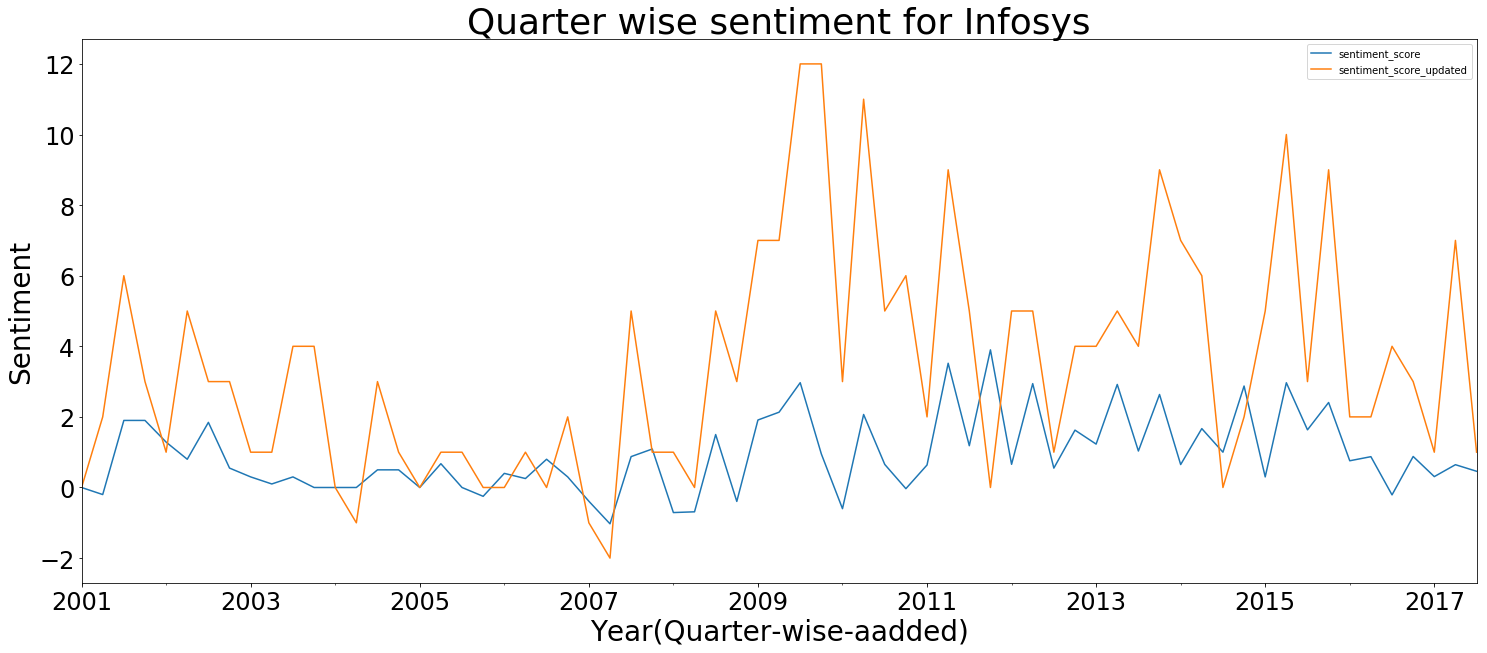

In [94]:
#Plotting sentiments using pandas time-series functionality

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
my_plt = aggregated_sentiment.plot(kind = 'line',figsize = (25,10))

plt.xlabel("Year(Quarter-wise-aadded)", fontsize = 28)
plt.ylabel("Sentiment", fontsize = 28)
plt.title("Quarter wise sentiment for Infosys", fontsize = 36)
plt.xticks(size = 24)
plt.yticks(size = 24)
plt.show()

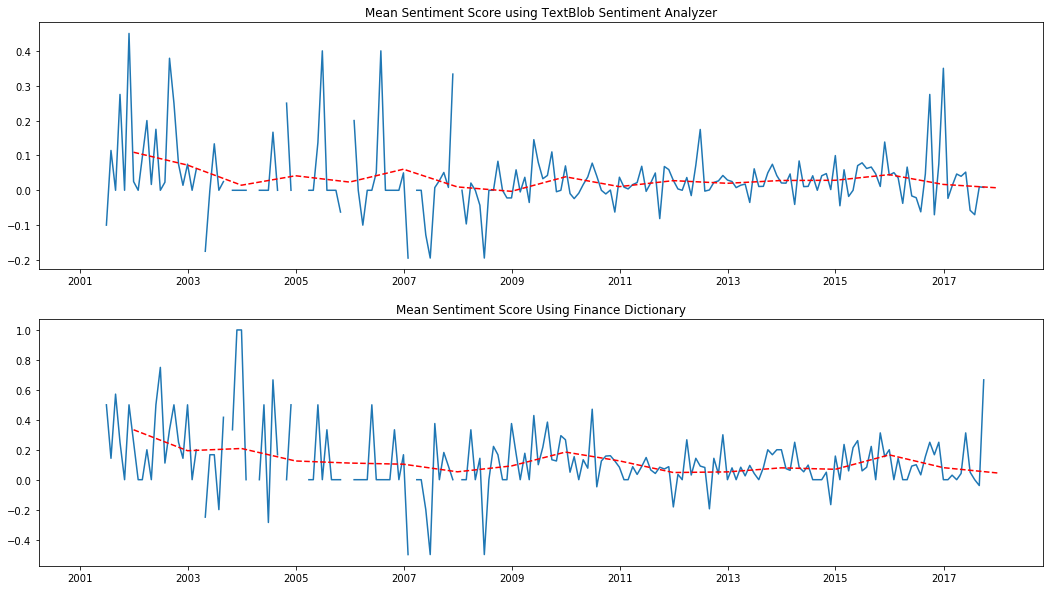

In [97]:
monthly_averages = infosys_df.resample('M').mean()
yearly_averages = infosys_df.resample('A').mean()

monthly_averages_stocks = stocks_df.resample('M').mean()
yearly_averages_stocks = stocks_df.resample('A').mean()

fig, ax = plt.subplots(2,figsize=(18,10))
ax[0].plot(monthly_averages['sentiment_score'])
ax[0].plot(yearly_averages['sentiment_score'], 'r--')
ax[0].set_title('Mean Sentiment Score using TextBlob Sentiment Analyzer')
ax[1].plot(monthly_averages['sentiment_score_updated'])
ax[1].plot(yearly_averages['sentiment_score_updated'], 'r--')
ax[1].set_title('Mean Sentiment Score Using Finance Dictionary')

# ax[2].plot(monthly_averages_stocks['Impact'])
# ax[2].plot(yearly_averages_stocks['Impact'], 'r--')
# ax[2].set_title('Mean change in Stock Price')